In [1]:
import ccxt
import pandas as pd
import numpy as np
import datetime
import time
import os
import json
from ta.trend import ADXIndicator, SMAIndicator, EMAIndicator
from ta.momentum import RSIIndicator, StochasticOscillator
import matplotlib.pyplot as plt

In [2]:
def tradechart(ohlc, longdata, shortdata, date_from, date_to):
    plt.figure(figsize=(16, 8))
    plt.title('Trades Chart')
    plt.plot(ohlc.close, label='Close Price')
    plt.plot(sma, label='SMA 18')
    # plt.plot(sma[date_from:date_to], label='SMA')
    # plt.plot(ema[date_from:date_to], label='EMA')

    plt.plot(longdata.startdate, longdata.entry_price, '^', color='lime', markersize=12, label='long enter')
    #plt.plot(shortdata.startdate, shortdata.entry_price, 'v', color='red', markersize=12, label='short enter')
    plt.plot(longdata.enddate, longdata.close_price, '.', color='red', markersize=6, label='long exit')
    #plt.plot(shortdata.enddate, shortdata.close_price, '.', color='lime', markersize=6, label='short exit')

    plt.xlabel('Date', fontsize=16)
    plt.ylabel('Price', fontsize=16)
    plt.legend()
    plt.show()


def clear():
    os.system('cls')  # on Windows System


def parse_dates(ts):
    return datetime.datetime.fromtimestamp(ts / 1000.0)


def get_market_data(ex, symbol, timeframe):
    # Getdata
    ohlc = None
    data = ex.fetch_ohlcv(symbol, timeframe, limit=200)
    df = pd.DataFrame(data)
    df.columns = (['ndatetime', 'open', 'high', 'low', 'close', 'volume'])
    df['datetime'] = df['ndatetime'].apply(parse_dates)

    # ohlc
    ohlc = df[['datetime', 'open', 'high', 'low', 'close']].copy()
    ohlc.set_index('datetime', drop=True, inplace=True)

    return ohlc


def get_market_data2(ex, symbol, timeframe, length):
    # Getdata
    exchange = ex
    multipier = {'1m': 60000, '5m': (60000 * 5), '15m': (60000 * 15), '1h': (
        60000 * 60), '4h': (60000 * 60 * 4), '1d': (60000 * 60 * 24),
        'weekly': (60000 * 60 * 24 * 7), 'monthly': (60000 * 60 * 24 * 30)}
    now = exchange.milliseconds()
    # since = exchange.parse8601('2020-09-22T00:00:00Z')
    since = now - (multipier[timeframe] * length)
    df = pd.DataFrame(None)
    ohlc = None
    while since < now:
        ohlcv = exchange.fetch_ohlcv(symbol, timeframe, since)
        since += len(ohlcv) * multipier[timeframe]

        dff = pd.DataFrame(ohlcv)
        df = pd.concat([df, dff], axis=0)

    df.columns = (['ndatetime', 'open', 'high', 'low', 'close', 'volume'])
    df['datetime'] = df['ndatetime'].apply(parse_dates)

    # ohlc
    ohlc = df[['datetime', 'open', 'high', 'low', 'close']].copy()
    ohlc.set_index('datetime', drop=True, inplace=True)

    # ohlc['hl2'] = round((ohlc['high'] + ohlc['low']) / 2, 1)
    # ohlc['hlc3'] = round((ohlc['high'] + ohlc['low'] + ohlc['close']) / 3, 1)
    # ohlc['ohlc4'] = round((ohlc['open'] + ohlc['high'] + ohlc['low'] + ohlc['close']) / 4, 1)

    return ohlc


def backtest(ohlc, capital=10000, risk=1, sl=50, tp=100, maxtrade=1):
    global trademanager
    global sma

    # Get Indicators Values
    indicator_sma = SMAIndicator(close=ohlc['close'], window=18)
    sma = indicator_sma.sma_indicator()
    strategy_setup = [0, 0, 0, 0, 0, 0]  # [setup1, setup2, setup3, close, low]

    # Backtest
    money = capital
    equity = capital
    risk = (risk/100)
    trademanager = np.zeros((maxtrade, 8))  # [active, type, entry_price, stoploss_price, takeprofit_price, qty, position_size, startdate]
    data = []
    longdata = []
    shortdata = []
    totaltrades = 0

    for i in range(50, len(ohlc)):
        # Trade Manager
        # [   0      1         2              3                4         5         6            7    ]
        # [active, type, entry_price, stoploss_price, takeprofit_price, qty, position_size, startdate]
        for ii in range(maxtrade):
            startdate = pd.Timestamp(trademanager[ii][7], unit='s')
            enddate = ohlc.index[i]
            if trademanager[ii][0] == 1 and trademanager[ii][1] == 1:  # 'Long'
                if ohlc['low'][i] <= trademanager[ii][3]:
                    pnl = abs((trademanager[ii][5]*trademanager[ii][3])-trademanager[ii][6])
                    money += trademanager[ii][6] - pnl
                    equity -= pnl
                    log = {'Side': 'Long', 'startdate': startdate, 'enddate': enddate, 'entry_price': trademanager[ii][2],
                           'stoploss_price': trademanager[ii][3], 'takeprofit_price': 'None', 'close_price': trademanager[ii][3],
                           'qty': trademanager[ii][5], 'position_size': round(trademanager[ii][6], 4), 'pnl': -round(pnl, 4), 'Equity': round(equity, 4)}
                    data.append(log)
                    longdata.append(log)
                    trademanager[ii] = np.zeros(8)
                    print(log)
                elif ohlc['high'][i] >= trademanager[ii][4]:
                    pnl = abs((trademanager[ii][5]*trademanager[ii][4])-trademanager[ii][6])
                    money += trademanager[ii][6] + pnl
                    equity += pnl
                    log = {'Side': 'Long', 'startdate': startdate, 'enddate': enddate, 'entry_price': trademanager[ii][2],
                           'stoploss_price': trademanager[ii][3], 'takeprofit_price': 'None', 'close_price': trademanager[ii][4],
                           'qty': trademanager[ii][5], 'position_size': round(trademanager[ii][6], 4), 'pnl': round(pnl, 4), 'Equity': round(equity, 4)}
                    data.append(log)
                    longdata.append(log)
                    trademanager[ii] = np.zeros(8)
                    print(log)

            elif trademanager[ii][0] == 1 and trademanager[ii][1] == 2:  # 'Short'
                if ohlc['high'][i] >= trademanager[ii][3]:
                    pnl = abs((trademanager[ii][5]*trademanager[ii][3])-trademanager[ii][6])
                    money += trademanager[ii][6] - pnl
                    equity -= pnl
                    log = {'Side': 'Short', 'startdate': startdate, 'enddate': enddate, 'entry_price': trademanager[ii][2],
                           'stoploss_price': trademanager[ii][3], 'takeprofit_price': trademanager[ii][4], 'close_price': trademanager[ii][3],
                           'qty': trademanager[ii][5], 'position_size': round(trademanager[ii][6], 4), 'pnl': -round(pnl, 4), 'Equity': round(equity, 4)}
                    data.append(log)
                    shortdata.append(log)
                    trademanager[ii] = np.zeros(8)
                    print(log)
                elif ohlc['low'][i] <= trademanager[ii][4]:
                    pnl = abs((trademanager[ii][5]*trademanager[ii][4])-trademanager[ii][6])
                    money += trademanager[ii][6] + pnl
                    equity += pnl
                    log = {'Side': 'Short', 'startdate': startdate, 'enddate': enddate, 'entry_price': trademanager[ii][2],
                           'stoploss_price': trademanager[ii][3], 'takeprofit_price': trademanager[ii][4], 'close_price': trademanager[ii][4],
                           'qty': trademanager[ii][5], 'position_size': round(trademanager[ii][6], 4), 'pnl': round(pnl, 4), 'Equity': round(equity, 4)}
                    data.append(log)
                    shortdata.append(log)
                    trademanager[ii] = np.zeros(8)
                    print(log)

        # ======================================================================================================================================================
        long_signal, entry, sl, tp, strategy_setup = strategy_check(i, ohlc, sma, strategy_setup)

        if long_signal == 1:   # LONG
            entryprice = entry  # ohlc['close'][i]
            stoploss_price = entryprice-sl
            takeprofit_price = entryprice+tp
            position_size = risk*capital
            qty = position_size/sl
            startdate = pd.Timestamp(ohlc.index[i]).timestamp()

            if trademanager[0][0] == 0:
                trademanager[0][0] = 1
                trademanager[0][1] = 1
                trademanager[0][2] = entryprice
                trademanager[0][3] = stoploss_price
                trademanager[0][4] = takeprofit_price
                trademanager[0][5] = qty
                trademanager[0][6] = position_size
                trademanager[0][7] = startdate
                money -= position_size
                totaltrades += 1

        elif long_signal == -1 and trademanager[0][0] == 1:   # SELL Immediately
            startdate = pd.Timestamp(trademanager[0][7], unit='s')
            enddate = ohlc.index[i]

            pnl = (trademanager[0][5]*entry)-trademanager[0][6]
            money += trademanager[0][6] + pnl
            equity += pnl
            log = {'Side': 'Long', 'startdate': startdate, 'enddate': enddate, 'entry_price': trademanager[0][2],
                   'stoploss_price': trademanager[0][3], 'takeprofit_price': 'None', 'close_price': entry,
                   'qty': trademanager[0][5], 'position_size': round(trademanager[0][6], 4), 'pnl': round(pnl, 4), 'Equity': round(equity, 4)}
            data.append(log)
            longdata.append(log)
            trademanager[0] = np.zeros(8)
            print(log)

        activetrades = sum(trademanager[:][0])

    return data, longdata, shortdata, equity


def strategy_check(i, ohlc, sma, strategy_setup):
    long_signal = 0
    entry = 0
    sl = 0
    tp = 0

    if ohlc['close'][i] > ohlc['open'][i]:
        bar = 1   # Green bar
    else:
        bar = -1  # Red bar

    # ========== LONG ===============================================================
    if sma[i] > sma[i-1] and sma[i-1] < sma[i-2]:
        if strategy_setup[0] != 1:
            strategy_setup = [1, 0, 0, 0, 0, 0]

    if strategy_setup[0] == 1 and strategy_setup[1] == 0 and bar == 1:
        a = abs(ohlc['open'][i]-ohlc['close'][i])
        b = 0
        for ii in range((i-period), i):
            b += abs(ohlc['open'][ii]-ohlc['close'][ii])
        b = b/period
        if a > (b*multiplier):
            strategy_setup[1] = 1
            strategy_setup[3] = ohlc['close'][i]
            strategy_setup[4] = ohlc['low'][i]
            strategy_setup[5] = ohlc.index[i]

    elif strategy_setup[1] == 1 and strategy_setup[2] == 0 and bar == 1:
        a = abs(ohlc['open'][i]-ohlc['close'][i])
        b = 0
        for ii in range((i-period), i):
            b += abs(ohlc['open'][ii]-ohlc['close'][ii])
        b = b/period
        if a > (b*multiplier) and ohlc['close'][i] > (strategy_setup[3]*1.03):
            strategy_setup[2] = 1

    # ========== SHORT ===============================================================
    if sma[i] < sma[i-1] and sma[i-1] > sma[i-2]:
        if strategy_setup[0] != -1:
            strategy_setup = [-1, 0, 0, 0, 0, 0]

    if strategy_setup[0] == -1 and strategy_setup[1] == 0 and bar == -1:
        a = abs(ohlc['open'][i]-ohlc['close'][i])
        b = 0
        for ii in range((i-period), i):
            b += abs(ohlc['open'][ii]-ohlc['close'][ii])
        b = b/period
        if a > (b*multiplier):
            strategy_setup[1] = -1
            strategy_setup[3] = ohlc['close'][i]
            strategy_setup[4] = ohlc['high'][i]
            strategy_setup[5] = ohlc.index[i]

    elif strategy_setup[1] == -1 and strategy_setup[2] == 0 and bar == -1:
        a = abs(ohlc['open'][i]-ohlc['close'][i])
        b = 0
        for ii in range((i-period), i):
            b += abs(ohlc['open'][ii]-ohlc['close'][ii])
        b = b/period
        if a > (b*multiplier) and ohlc['close'][i] < (strategy_setup[3]*0.97):
            strategy_setup[2] = -1

    # ================================================================================
    if strategy_setup[0] == 1 and strategy_setup[1] == 1 and strategy_setup[2] == 1:
        long_signal = 1
        entry = ohlc['close'][i]
        sl = abs(entry-strategy_setup[4])
        if trademanager[0][0] == 0:
            print('\nfirst Wide Bar: {}, Second Wide Bar: {}'.format(strategy_setup[5], ohlc.index[i]))
        tp = sl*5000
        strategy_setup = [0, 0, 0, 0, 0]
    elif strategy_setup[0] == -1 and strategy_setup[1] == -1 and strategy_setup[2] == -1:
        long_signal = -1
        entry = ohlc['close'][i]
        strategy_setup = [0, 0, 0, 0, 0]
    # ================================================================================

    return long_signal, entry, sl, tp, strategy_setup

Loading Setting...
...................... Done
Loading Market Data...
...................... Done
Running Backtest...

first Wide Bar: 2015-11-29 01:00:00, Second Wide Bar: 2015-12-05 01:00:00
{'Side': 'Long', 'startdate': Timestamp('2015-12-05 01:00:00'), 'enddate': Timestamp('2015-09-25 01:00:00'), 'entry_price': 394.0, 'stoploss_price': 355.1, 'takeprofit_price': 'None', 'close_price': 355.1, 'qty': 2.5706940874036004, 'position_size': 100.0, 'pnl': -812.8535, 'Equity': 9187.1465}

first Wide Bar: 2015-10-13 01:00:00, Second Wide Bar: 2015-10-16 01:00:00
{'Side': 'Long', 'startdate': Timestamp('2015-10-16 01:00:00'), 'enddate': Timestamp('2016-08-02 01:00:00'), 'entry_price': 263.89, 'stoploss_price': 244.47, 'takeprofit_price': 'None', 'close_price': 528.83, 'qty': 5.14933058702369, 'position_size': 100.0, 'pnl': 2623.1205, 'Equity': 11810.267}

first Wide Bar: 2016-09-02 01:00:00, Second Wide Bar: 2016-09-03 01:00:00
{'Side': 'Long', 'startdate': Timestamp('2016-09-03 01:00:00'), 

C:\Anaconda\lib\site-packages\matplotlib\cbook\__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
C:\Anaconda\lib\site-packages\matplotlib\axes\_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
C:\Anaconda\lib\site-packages\matplotlib\axes\_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


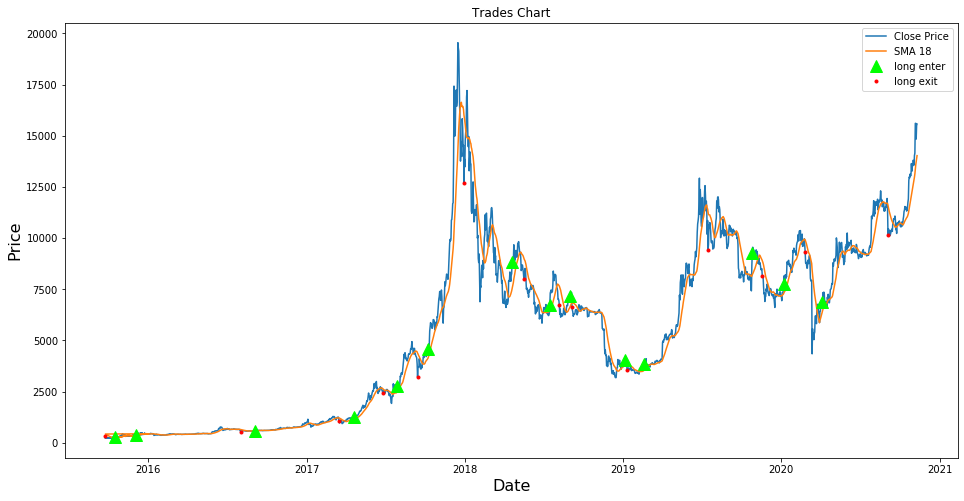

In [3]:
if __name__ == '__main__':
    global period
    global multiplier

    # ==============SETTINGS======================================================================================================================
    # Test Net Settings
    print('Loading Setting...')
    exchange_settings = {'apiKey': '',
                         'secret': '',
                         'enableRateLimit': True, 'options': {'adjustForTimeDifference': True}}

    # load exchange
    bitmex = ccxt.bitmex(exchange_settings)
    bitmex.set_sandbox_mode(True)
    ex = bitmex
    # =============================================================================================================================================
    # Real Net Settings
    exchange_settings2 = {'apiKey': '',
                          'secret': '',
                          'enableRateLimit': True, 'options': {'adjustForTimeDifference': True}}

    # load exchange
    bitmex2 = ccxt.bitmex(exchange_settings2)
    bitmex2.set_sandbox_mode(False)
    ex2 = bitmex2
    # =============================================================================================================================================

    # load all markets
    markets = ex.load_markets()
    df = pd.DataFrame(markets)
    all_markets = df.columns.values
    # print(all_markets)

    tf = '5m'
    clock = {'1m': 4, '5m': 4, '15m': 4, '30m': 4, '1h': 3, '4h': 3, '1d': 2}
    timecheck = {'1m': [i for i in range(0, 60)], '5m': [i for i in range(0, 60, 5)],
                 '15m': [i for i in range(0, 60, 15)], '30m': [i for i in range(0, 60, 30)],
                 '1h': [i for i in range(0, 60)], '4h': [i for i in range(0, 60, 4)], '1d': [i for i in range(0, 30)]}
    lasttime = {'1m': 90, '5m': 90, '15m': 90, '30m': 90, '1h': 90, '4h': 90, '1d': 90}

    symbol = 'BTC/USD'     #you can change symbol here
    ohlc_setting = 'daily' #['daily', 'weekly', 'monthly'] you can change time frame here
    print('...................... Done')
    # =============================================================================================================================================

    # Load OHLC Data
    print('Loading Market Data...')
    #ohlc = get_market_data(ex2, symbol, '1d')
    daily_ohlc = get_market_data2(ex2, symbol, '1d', 2000)
    #weekly_ohlc = ohlc2.resample('W').last()
    #monthly_ohlc = ohlc2.resample('M').last()

    if ohlc_setting == 'daily':
        ohlc = daily_ohlc.copy()
    elif ohlc_setting == 'weekly':
        ohlc = daily_ohlc.resample('W').last()
    elif ohlc_setting == 'monthly':
        ohlc = daily_ohlc.resample('M').last()

    period = 4
    multiplier = 1.14
    print('...................... Done')

    # Start Backtest
    print('Running Backtest...')
    data, longdata, shortdata, equity = backtest(ohlc)
    print('...................... Done')

    df = pd.DataFrame(data)
    longdata = pd.DataFrame(longdata)
    shortdata = pd.DataFrame(shortdata)

    df.set_index('startdate', drop=False, inplace=True)
    longdata.set_index('startdate', drop=False, inplace=True)
    #shortdata.set_index("startdate", drop=False, inplace=True)

    print('Total Equity: ', round(equity, 4))
    tradechart(ohlc, longdata, shortdata, '01/12/2019', '01/06/2020')

